In [1]:
from spectral_cube import SpectralCube
from pvextractor import extract_pv_slice, Path
import pylab as pl
import numpy as np
from astropy.visualization import quantity_support
from astropy import units as u
from astropy import wcs
from matplotlib.colors import LogNorm
from astropy.visualization.stretch import SinhStretch
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt
from astropy.utils import data
from cycler import cycler
from itertools import cycle
from scipy.stats import ks_2samp
from scipy.optimize import fsolve
from spectral_cube import Projection
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles

fatal: detected dubious ownership in repository at '/blue/adamginsburg/adamginsburg/repos/dask'
To add an exception for this directory, call:

	git config --global --add safe.directory /blue/adamginsburg/adamginsburg/repos/dask


# Data

In [2]:
a_fixednames =['/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.12CO.spw17.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.Ha.spw19.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.CH3OH.spw21.fits',
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.H2CO.spw23.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.H2CO.spw25.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.SiO.spw27.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.13CO.spw29.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.C18O.spw31.fits' 
               ]
cube_17 = SpectralCube.read(a_fixednames[0]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
#cube_21 = SpectralCube.read(a_fixednames[2]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
#cube_23 = SpectralCube.read(a_fixednames[3]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
#cube_25 = SpectralCube.read(a_fixednames[4]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
#cube_27 = SpectralCube.read(a_fixednames[5]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_29 = SpectralCube.read(a_fixednames[6]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_31 = SpectralCube.read(a_fixednames[7]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')


In [3]:
def noise_mask(cube, vmin, vmax, level):
    noise = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_slab(vmin, vmax).std(axis=0)
    peak = cube.max(axis=0)
    spatial_mask = peak > level * noise
    return spatial_mask

def noise_mask_slab(cube, vmin, vmax, level, cut1, cut2):
    noise = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_slab(vmin, vmax).std(axis=0)
    peak = cube.spectral_slab(cut1, cut2).max(axis=0)
    spatial_mask = peak > level * noise
    return spatial_mask

def get_x(mom0):
    ww = wcs.WCS(mom0.header)
    pixelarea = ww.proj_plane_pixel_area()#.to(u.sr)
    #np.sqrt(pixelarea.to(u.rad**2)).to(u.arcsecond)
    x = range(mom0.shape[1]) * np.sqrt(pixelarea.to(u.rad**2)).to(u.arcmin)
    return x

def t_kin(ratio):
    # ratio of spw 23 / spw 25
    return 590*np.power(ratio, 2) + 2.88*ratio + 23.4

In [4]:
mask_17 = noise_mask(cube_17, -100*u.km/u.second, -50 *u.km/u.second, 5)
#mask_23 = noise_mask(cube_23, 50*u.km/u.second, 80 *u.km/u.second, 5)
#mask_25 = noise_mask(cube_25, -100*u.km/u.second, -50 *u.km/u.second, 5)
#mask_27 = noise_mask(cube_27, -100*u.km/u.second, -50 *u.km/u.second, 5)


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


In [5]:
mask_29 = noise_mask(cube_29, -100*u.km/u.second, -50 *u.km/u.second, 5)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


In [6]:
mask_31 = noise_mask(cube_31, -100*u.km/u.second, -50 *u.km/u.second, 6)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to  9.403e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.361e+02 [aplpy.core]


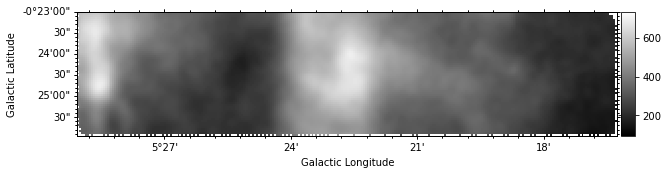

In [7]:
mom0_17 = cube_17.with_mask(mask_17).spectral_slab(15*u.km/u.s, 225*u.km/u.s).moment0()
mom0_17.quicklook()
#mom0_17.FITSFigure.add_beam()

INFO: Auto-setting vmin to -2.155e-01 [aplpy.core]
INFO: Auto-setting vmax to  5.005e+01 [aplpy.core]


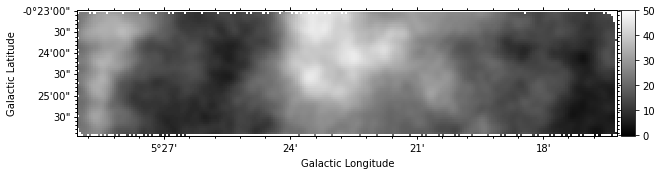

In [8]:
mom0_29 = cube_29.with_mask(mask_29).spectral_slab(15*u.km/u.s, 225*u.km/u.s).moment0()
mom0_29.quicklook()
#mom0_29.FITSFigure.add_beam()

INFO: Auto-setting vmin to -5.386e-01 [aplpy.core]
INFO: Auto-setting vmax to  5.462e+00 [aplpy.core]


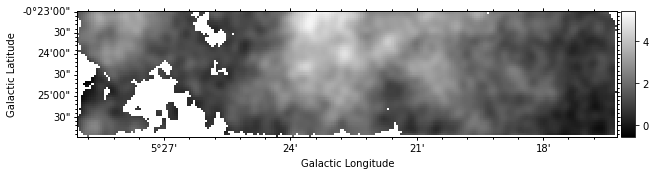

In [9]:
mom0_31 = cube_31.with_mask(mask_31).spectral_slab(15*u.km/u.s, 225*u.km/u.s).moment0()
mom0_31.quicklook()
#mom0_31.FITSFigure.add_beam()

# Ratios

### $^{12}$CO / $^{13}$CO

INFO: Auto-setting vmin to  7.929e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.625e+01 [aplpy.core]


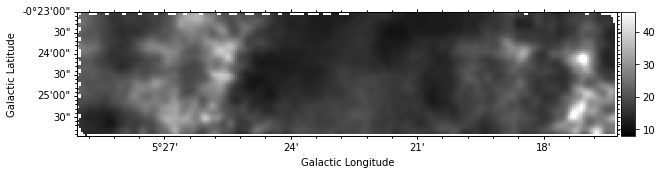

In [10]:
ratio_1729 = mom0_17 / mom0_29.reproject(mom0_17.header)
#cube_17.with_mask(mask_17).spectral_slab(15*u.km/u.s, 225*u.km/u.s).moment0() / cube_29.with_mask(mask_29).reproject(cube_17.header).with_mask(mask_17).spectral_slab(15*u.km/u.s, 225*u.km/u.s).moment0()
ratio_1729.quicklook()

In [11]:
#ratio_max_1729 = cube_17.with_mask(mask_17).max(axis=0) / cube_29.with_mask(mask_29).reproject(cube_17.header).with_mask(mask_17).max(axis=0)
#ratio_max_1729.quicklook()

In [12]:
#print(np.nanmin(ratio_max_1729), np.nanmax(ratio_max_1729), np.nanmean(ratio_max_1729), np.nanmedian(ratio_max_1729))

INFO: Auto-setting vmin to  7.831e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.727e+01 [aplpy.core]


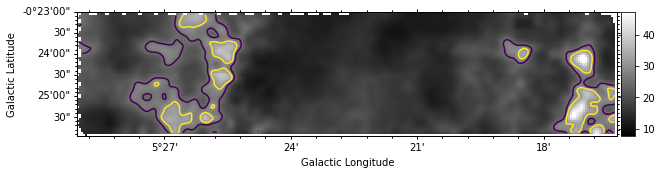

In [13]:
rat_1729 = ratio_1729*1.0
rat_1729.quicklook()
rat_1729.FITSFigure.show_contour(rat_1729.hdu, levels=[25,30])

### $^{13}$CO / C$^{18}$O

INFO: Auto-setting vmin to  6.111e-01 [aplpy.core]
INFO: Auto-setting vmax to  5.947e+01 [aplpy.core]


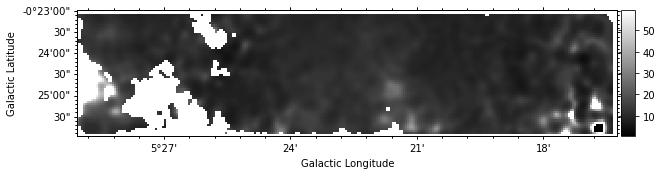

In [14]:
ratio_2931 = mom0_29 / mom0_31.reproject(mom0_29.header)
#cube_29.with_mask(mask_29).spectral_slab(15*u.km/u.s, 225*u.km/u.s).moment0() / cube_31.with_mask(mask_31).reproject(cube_29.header).with_mask(mask_29).spectral_slab(15*u.km/u.s, 225*u.km/u.s).moment0()
ratio_2931[ratio_2931<-50] = np.nan
ratio_2931[ratio_2931>100] = np.nan
ratio_2931.quicklook()

In [15]:
print(np.nanmean(ratio_2931), np.nanmedian(ratio_2931), np.nanmax(ratio_2931), np.nanmin(ratio_2931), np.nanstd(ratio_2931))

12.156441745828035 10.894092134083234 97.15998586225395 -48.728058806434134 5.963115217451987


In [16]:
#ratio_max_2931 = cube_29.with_mask(mask_29).max(axis=0) / cube_31.with_mask(mask_31).reproject(cube_29.header).with_mask(mask_29).max(axis=0)
#ratio_max_2931.quicklook()

In [17]:
#print(np.nanmin(ratio_max_2931), np.nanmax(ratio_max_2931), np.nanmean(ratio_max_2931), np.nanmedian(ratio_max_2931))

### $^{12}$CO / C$^{18}$O

INFO: Auto-setting vmin to  1.765e+01 [aplpy.core]
INFO: Auto-setting vmax to  9.748e+02 [aplpy.core]


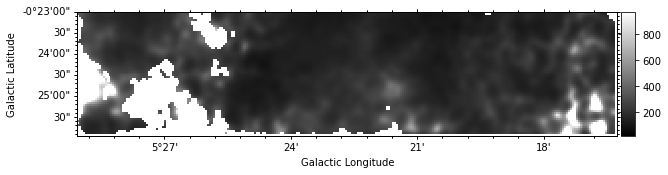

In [18]:
ratio_1731 = mom0_17 / mom0_31.reproject(mom0_17.header)
ratio_1731[ratio_1731<0] = np.nan
ratio_1731[ratio_1731>1000] = np.nan
#cube_17.with_mask(mask_17).spectral_slab(15*u.km/u.s, 225*u.km/u.s).moment0() / cube_31.with_mask(mask_31).reproject(cube_17.header).with_mask(mask_17).spectral_slab(15*u.km/u.s, 225*u.km/u.s).moment0()
ratio_1731.quicklook()

In [19]:
#ratio_max_1731 = cube_17.with_mask(mask_17).max(axis=0) / cube_31.with_mask(mask_31).reproject(cube_17.header).with_mask(mask_17).max(axis=0)
#ratio_max_1731.quicklook()

In [20]:
print(np.nanmin(ratio_1731), np.nanmax(ratio_1731), np.nanmean(ratio_1731), np.nanmedian(ratio_1731))

87.79728247335856 999.6768979054813 217.11181983313088 190.89966888823474


In [21]:
#rat_1731 = ratio_1731*1.0#cube_17.with_mask(mask_17).moment0() / cube_31.reproject(cube_17.header).with_mask(mask_17).moment0()
#rat_1731[rat_1731 < 0] = np.nan
#rat_1731[rat_1731 > 1000] = np.nan
#rat_1731.quicklook()

In [22]:
#np.nanmean(rat_1731, axis=0)

In [23]:
25*12

300

# Opacity

## 12C/13C = 25

In [24]:
def funct(tau, A): # = R
    #A = 30
    return (1-np.e**(-tau))/(1-np.e**(-tau/A))

def F(tau, R=20, A=25):
    return R - funct(tau, A)

In [25]:
taus_all = np.ones(np.nan_to_num(ratio_1729).shape)
rat_all = np.nan_to_num(ratio_1729)

for t in range(len(taus_all)):
    taus_all[t] = (fsolve(F, taus_all[t], rat_all[t]))*(rat_all[t] != 0)
    

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


INFO: Auto-setting vmin to -1.373e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.359e+00 [aplpy.core]


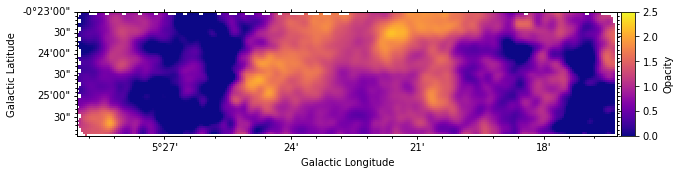

In [26]:
pro4 = Projection(value=taus_all, wcs=ratio_1729.wcs)
pro4[pro4==0]=np.nan
pro4.quicklook()
pro4.FITSFigure.show_colorscale(cmap='plasma', vmin=0, vmax=2.5)
pro4.FITSFigure.colorbar.set_axis_label_text('Opacity')
#pro4.savefig('/orange/adamginsburg/cmz/g5/code/plots/opa1213.fits')
pro4.hdu.writeto('/orange/adamginsburg/cmz/g5/code/plots/opa1213.fits', overwrite=True)

In [27]:
np.nanmedian(pro4)

<Quantity 0.77256226>

### 12C/13C = 40

In [28]:
def F_40(tau, R=20, A=40):
    return R - funct(tau, A)

In [29]:
taus_all_40 = np.ones(np.nan_to_num(ratio_1729).shape)
rat_all_40 = np.nan_to_num(ratio_1729)

for t in range(len(taus_all_40)):
    taus_all_40[t] = (fsolve(F_40, taus_all_40[t], rat_all_40[t]))*(rat_all_40[t] != 0)
    

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/scratch/local/55074977/ipykernel_31561/2822913080.py:3: RuntimeWarning: overflow encountered in power
  return (1-np.e**(-tau))/(1-np.e**(-tau/A))


INFO: Auto-setting vmin to -4.640e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.065e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.008e+00 [aplpy.core]


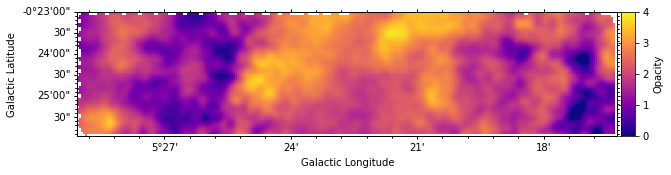

In [30]:
pro4_40 = Projection(value=taus_all_40, wcs=ratio_1729.wcs)
pro4_40[pro4_40==0]=np.nan
pro4_40.quicklook()
pro4_40.FITSFigure.show_colorscale(cmap='plasma', vmin=0)#, vmax=2.5)
pro4_40.FITSFigure.colorbar.set_axis_label_text('Opacity')
#pro4_40.savefig('/orange/adamginsburg/cmz/g5/code/plots/opa1213.fits')
pro4_40.hdu.writeto('/orange/adamginsburg/cmz/g5/code/plots/opa1213_40.fits', overwrite=True)

In [31]:
np.nanmedian(pro4_40)

<Quantity 2.00744265>

### 16O/18O = 250

In [32]:
def F_1218(tau, R=200, A=250):
    return R - funct(tau, A)

In [33]:
taus_alt_full = np.ones(np.nan_to_num(ratio_1731).shape)
rat_alt_full = np.nan_to_num(ratio_1731)

for t in range(len(taus_alt_full)):
    for ii in range(len(taus_alt_full[0])):
        taus_alt_full[t][ii] = (fsolve(F_1218, taus_alt_full[t][ii], rat_alt_full[t][ii]))*(rat_alt_full[t][ii] != 0)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


INFO: Auto-setting vmin to -2.609e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.854e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.599e+00 [aplpy.core]


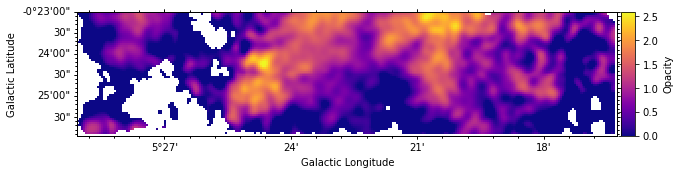

In [34]:
pro4_alt_full = Projection(value=taus_alt_full, wcs=ratio_1731.wcs)
pro4_alt_full[pro4_alt_full==0] = np.nan
pro4_alt_full[pro4_alt_full==1] = np.nan
pro4_alt_full[pro4_alt_full>400] = np.nan
pro4_alt_full.quicklook()
pro4_alt_full.FITSFigure.show_colorscale(cmap='plasma', vmin=0)#, vmax=2.5)
pro4_alt_full.FITSFigure.colorbar.set_axis_label_text('Opacity')
pro4_alt_full.hdu.writeto('/orange/adamginsburg/cmz/g5/code/plots/opa1218.fits', overwrite=True)

In [35]:
np.nanmax(pro4_alt_full)

<Projection 2.66302874>

In [36]:
np.nanmedian(pro4_alt_full)

<Quantity 0.56856646>

### 16O/18O = 275

In [37]:
def F_1218_275(tau, R=200, A=275):
    return R - funct(tau, A)

In [38]:
taus_alt_full_275 = np.ones(np.nan_to_num(ratio_1731).shape)
rat_alt_full_275 = np.nan_to_num(ratio_1731)

for t in range(len(taus_alt_full_275)):
    for ii in range(len(taus_alt_full_275[0])):
        taus_alt_full_275[t][ii] = (fsolve(F_1218_275, taus_alt_full_275[t][ii], rat_alt_full_275[t][ii]))*(rat_alt_full_275[t][ii] != 0)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


INFO: Auto-setting vmin to -2.484e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.102e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.883e+00 [aplpy.core]


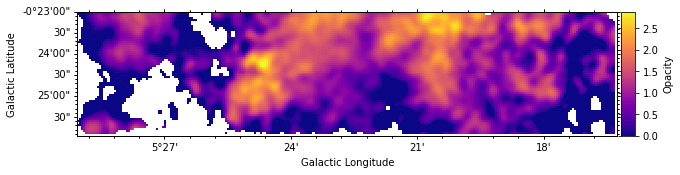

In [39]:
pro4_alt_full_275 = Projection(value=taus_alt_full_275, wcs=ratio_1731.wcs)
pro4_alt_full_275[pro4_alt_full_275==0] = np.nan
pro4_alt_full_275[pro4_alt_full_275==1] = np.nan
pro4_alt_full_275[pro4_alt_full_275>400] = np.nan
pro4_alt_full_275.quicklook()
pro4_alt_full_275.FITSFigure.show_colorscale(cmap='plasma', vmin=0)#, vmax=2.5)
pro4_alt_full_275.FITSFigure.colorbar.set_axis_label_text('Opacity')
pro4_alt_full_275.hdu.writeto('/orange/adamginsburg/cmz/g5/code/plots/opa1218_275.fits', overwrite=True)

In [40]:
np.nanmax(pro4_alt_full_275)

<Projection 2.99108239>

In [41]:
np.nanmedian(pro4_alt_full_275)

<Quantity 0.78383615>

In [42]:
11*40

440

### 16O/18O = 440

In [43]:
def F_1218_440(tau, R=200, A=440):
    return R - funct(tau, A)

In [44]:
taus_alt_full_440 = np.ones(np.nan_to_num(ratio_1731).shape)
rat_alt_full_440 = np.nan_to_num(ratio_1731)

for t in range(len(taus_alt_full_440)):
    for ii in range(len(taus_alt_full_440[0])):
        taus_alt_full_440[t][ii] = (fsolve(F_1218_440, taus_alt_full_440[t][ii], rat_alt_full_440[t][ii]))*(rat_alt_full_440[t][ii] != 0)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


INFO: Auto-setting vmin to -1.809e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.053e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.995e+00 [aplpy.core]


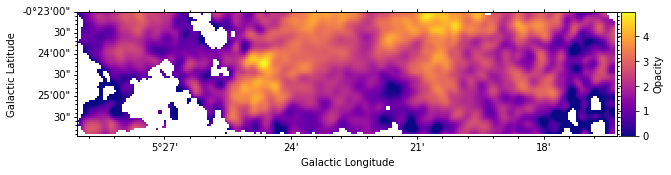

In [45]:
pro4_alt_full_440 = Projection(value=taus_alt_full_440, wcs=ratio_1731.wcs)
pro4_alt_full_440[pro4_alt_full_440==0] = np.nan
pro4_alt_full_440[pro4_alt_full_440==1] = np.nan
pro4_alt_full_440[pro4_alt_full_440>400] = np.nan
pro4_alt_full_440.quicklook()
pro4_alt_full_440.FITSFigure.show_colorscale(cmap='plasma', vmin=0)#, vmax=2.5)
pro4_alt_full_440.FITSFigure.colorbar.set_axis_label_text('Opacity')
pro4_alt_full_440.hdu.writeto('/orange/adamginsburg/cmz/g5/code/plots/opa1218_440.fits', overwrite=True)

In [46]:
np.nanmax(pro4_alt_full_440)

<Projection 5.00636512>

In [47]:
np.nanmedian(pro4_alt_full_440)

<Quantity 1.99631493>

# Selection Velocity Bridge

In [48]:
velo = cube_17.spectral_axis # 50-100/125 km/s
lat = cube_17.spatial_coordinate_map[0]
long = cube_17.spatial_coordinate_map[1] # 5-8 arcmin
ran_long = long[(long>(np.max(long) - 8.5*u.arcmin)) & (long< (np.max(long) - 4.5*u.arcmin))]
ran_velo = velo[(velo > 50*u.km/u.second) & (velo < 100*u.km/u.second)]

In [49]:
sub_cube = cube_17.subcube(xlo=np.max(long) - 9.5*u.arcmin, xhi=np.max(long) - 4*u.arcmin, zlo=15*u.km/u.second, zhi=200*u.km/u.second)

INFO: Auto-setting vmin to  1.495e+02 [aplpy.core]
INFO: Auto-setting vmax to  7.319e+02 [aplpy.core]


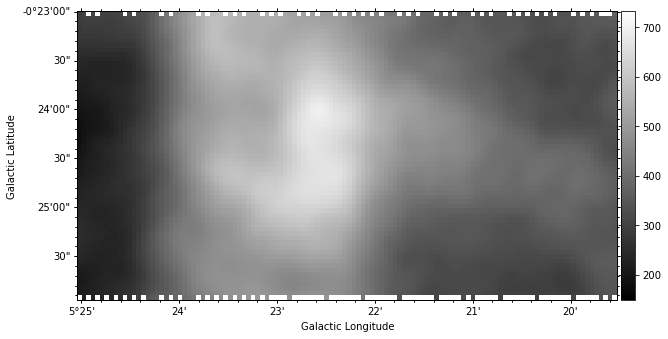

In [50]:
sub_cube.moment0().quicklook()

In [51]:
smom0 = sub_cube.moment0(axis=1)

In [52]:
x = sub_cube.spatial_coordinate_map[1]
y = x[0].value*(10)/(np.max(x[0]).value-np.min(x[0]).value) + 50

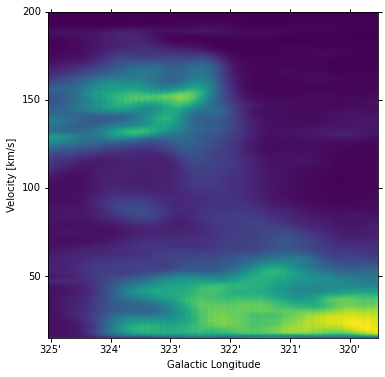

In [53]:
fig = pl.figure(figsize=(6,6))
ax = pl.subplot(111, projection=wcs.WCS(smom0.header))
im = ax.imshow(smom0.data)
ax0 = ax.coords[0]
ax0.set_format_unit(u.arcmin)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)
ax.set_ylabel("Velocity [km/s]")
#ax.set_xlabel("Offset in Longtit
ax.set_xlabel("Galactic Longitude")
ax.set_aspect(0.1)
#ax.scatter(x[0].to_pixel(), y, color='red')
#ax.scatter(50, 50, color='red')

In [54]:
def get_y(x, p1x, p1y, p2x, p2y):
    return (p1y - p2y)/(p1x - p2x)*x + p1y - p1x*(p1y - p2y)/(p1x - p2x)

In [90]:
x = np.arange(smom0.data.shape[1])
# y = (p1y - p2y)/(p1x - p2x)*x + p1y - p1x*(p1y - p2y)/(p1x - p2x)
y = get_y(x, 55, 350, 85, 460)         #(260 - 350)/(55 - 100)*x + 260 - 55*(260 - 350)/(55 - 100)
y_2 = get_y(x, 85, 460, 75, 700)         #x*(700-260)/(40-55) + 700-40*(700-260)/(40-55)
y_3 = get_y(x, 75, 700, 40, 600)         #get_y(x, 40, 600, 80, 880) #(700 - 900)/(40 - 65)*x + 700 - 40*(700 - 900)/(40 - 65)
#p1 =          #(100, 350)
#p2 =          #(65, 900)
y_4 = get_y(x, 40, 600, 55, 350)         #(350 - 900)/(100 - 65)*x + 350 - 100*(350 - 900)/(100 - 65)

#ax.scatter(85, 460)
#ax.scatter(75, 700)

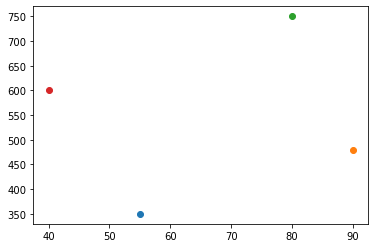

In [91]:
plt.scatter(55, 350)
plt.scatter(90, 480)
plt.scatter(80, 750)
plt.scatter(40, 600)


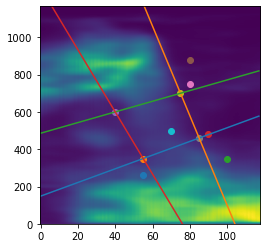

In [92]:
ax = pl.subplot(111)
ax.imshow((smom0).data)
#ax.imshow((smom0*trap).data)
ax.set_aspect(0.1)
plt.gca().invert_yaxis()
ax.plot(x, y  ) # (55,260), (100,350)
ax.plot(x, y_2) # (40,700), (55,260)
ax.plot(x, y_3) # (40,700), (65,900)
ax.plot(x, y_4) # (100,350), (65,900)
#ax.scatter(40, 700)
ax.scatter(55, 260)
ax.scatter(55, 350)

ax.scatter(100, 350)
ax.scatter(90, 480)
#ax.scatter(65, 900)

ax.scatter(40, 600)
ax.scatter(80, 880)
ax.scatter(80, 750)

ax.scatter(85, 460)
ax.scatter(75, 700)

ax.set_ylim(top=smom0.data.shape[0], bottom=0)
ax.scatter(70, 500)

In [93]:
def cross_product(xA, yA, x1, y1, x2, y2): 
    v1 = (x2-x1, y2-y1)   # Vector 1
    v2 = (x2-xA, y2-yA)   # Vector 2
    xp = v1[0]*v2[1] - v1[1]*v2[0]  # Cross product
    above = False
    if xp < 0:
        above = True
        #print('on one side')
    return above

In [94]:
#y = get_y(x, 55, 350, 90, 480)     
#y_2 = get_y(x, 90, 480, 80, 750)   
#y_3 = get_y(x, 80, 750, 40, 600)   
##p1 =          #(100, 350)
##p2 =          #(65, 900)
#y_4 = get_y(x, 40, 600, 55, 350)   

In [95]:
mask = smom0.mask.include()
xA = 70
yA = 500
#cross_product(xA, yA, 55, 350, 90, 480) # y
#cross_product(xA, yA, 90, 480, 80, 750) # y_2
#cross_product(xA, yA, 80, 750, 40, 600) # y_3
#cross_product(xA, yA, 40, 600, 55, 350) # y_4

In [96]:
trap = np.full(mask.shape, False)
#ax.scatter(85, 460)
#ax.scatter(75, 700)

for yA in range(trap.shape[0]):
    for xA in range(trap.shape[1]):
        check1 = cross_product(xA, yA, 55, 350, 85, 460)
        check2 = cross_product(xA, yA, 85, 460, 75, 700)
        check3 = cross_product(xA, yA, 75, 700, 40, 600)
        check4 = cross_product(xA, yA, 40, 600, 55, 350)
        trap[yA, xA] = check1 and check2 and check3 and check4

INFO: Auto-setting vmin to -8.324e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.140e+02 [aplpy.core]


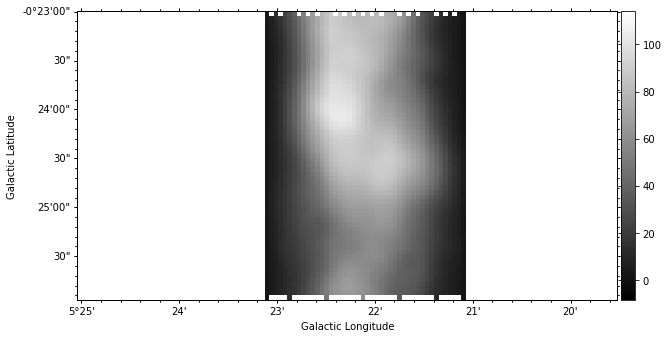

In [97]:
sub_cube.with_mask(trap[:, None, :]).moment0().quicklook()

In [98]:
sub_cube_29 = cube_29.with_mask(mask_29).reproject(cube_17.header).subcube(xlo=np.max(long) - 9.5*u.arcmin, xhi=np.max(long) - 4*u.arcmin, zlo=15*u.km/u.second, zhi=200*u.km/u.second)

INFO: Auto-setting vmin to -6.076e-01 [aplpy.core]
INFO: Auto-setting vmax to  5.285e+00 [aplpy.core]


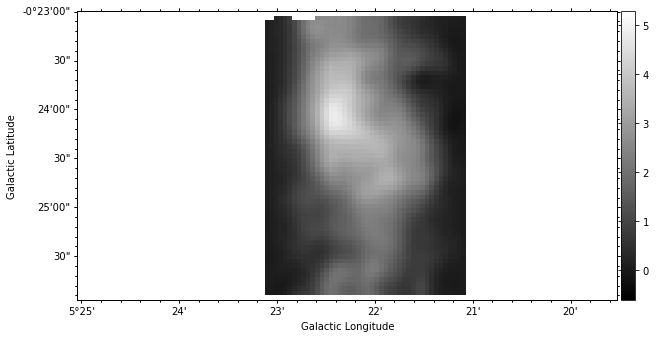

In [99]:
submom0_29 = sub_cube_29.with_mask(trap[:, None, :]).moment0()
submom0_29.quicklook()

In [100]:
sub_cube_31 = cube_31.with_mask(mask_31).reproject(cube_17.header).subcube(xlo=np.max(long) - 9.5*u.arcmin, xhi=np.max(long) - 4*u.arcmin, zlo=15*u.km/u.second, zhi=200*u.km/u.second)

INFO: Auto-setting vmin to -3.995e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.443e-01 [aplpy.core]


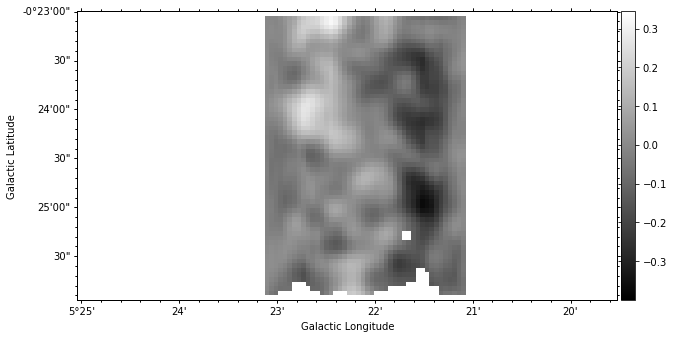

In [101]:
submom0_31 = sub_cube_31.with_mask(trap[:, None, :]).moment0()
submom0_31.quicklook()

INFO: Auto-setting vmin to  1.744e+01 [aplpy.core]
INFO: Auto-setting vmax to  6.381e+01 [aplpy.core]


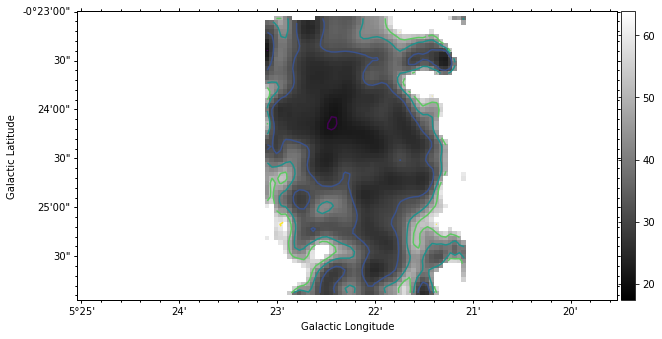

In [102]:
ratio_bridge = sub_cube.with_mask(trap[:, None, :]).moment0(axis=0) / sub_cube_29.with_mask(trap[:, None, :]).moment0(axis=0)
ratio_bridge[ratio_bridge<0] = np.nan
ratio_bridge[ratio_bridge>60] = np.nan
ratio_bridge.quicklook()
levs = ratio_bridge.FITSFigure.show_contour(ratio_bridge.hdu, returnlevels=True)


In [103]:
#print(np.nanmin(ratio_bridge), np.nanmax(ratio_bridge), np.nanmean(ratio_bridge), np.nanmedian(ratio_bridge))

In [104]:
levs

array([21.2710439 , 30.85234035, 40.43363679, 50.01493323, 59.59622967])

In [105]:
np.nanstd(ratio_bridge)

<Projection 8.61825601>

In [106]:
np.nanmean(ratio_bridge)

<Projection 33.91812952>

In [107]:
np.nanmedian(ratio_bridge)

<Quantity 31.58575994>

In [123]:
def F(tau, R=20, A=30):
    return R - funct(tau, A)

In [124]:
taus_bridge = np.ones(np.nan_to_num(ratio_bridge).shape)
rat_bridge = np.nan_to_num(ratio_bridge)

for t in range(len(taus_bridge)):
    taus_bridge[t] = (fsolve(F, taus_bridge[t], rat_bridge[t]))*(rat_bridge[t] != 0)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/scratch/local/55074977/ipykernel_31561/2822913080.py:3: RuntimeWarning: overflow encountered in power
  return (1-np.e**(-tau))/(1-np.e**(-tau/A))
/scratch/local/55074977/ipykernel_31561/2822913080.py:3: RuntimeWarning: invalid value encountered in divide
  return (1-np.e**(-tau))/(1-np.e**(-tau/A))


INFO: Auto-setting vmin to -1.485e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.857e-01 [aplpy.core]
INFO: Auto-setting vmax to  8.372e-01 [aplpy.core]


array([21.2710439 , 30.85234035, 40.43363679, 50.01493323, 59.59622967])

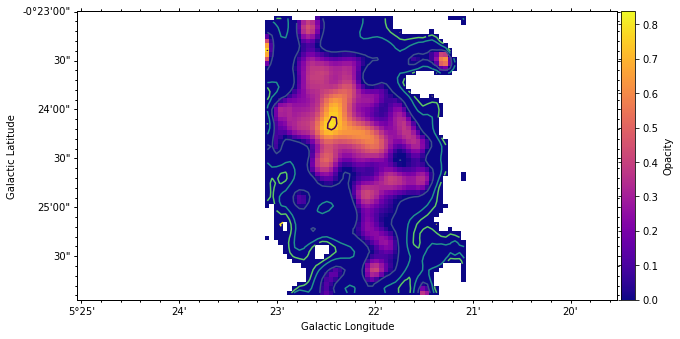

In [125]:
pro4_bridge = Projection(value=taus_bridge, wcs=ratio_bridge.wcs)
pro4_bridge[pro4_bridge==0] = np.nan
#pro4_bridge[pro4_bridge>2.4] = np.nan
pro4_bridge.quicklook()
pro4_bridge.FITSFigure.show_colorscale(cmap='plasma', vmin=0)
pro4_bridge.FITSFigure.colorbar.set_axis_label_text('Opacity')
pro4_bridge.FITSFigure.show_contour(ratio_bridge.hdu, returnlevels=True)

In [111]:
print(np.nanmin(pro4_bridge), np.nanmax(pro4_bridge), np.nanmean(pro4_bridge), np.nanmedian(pro4_bridge))

-1.2910633802359275 0.7925874619100807 -0.17189657134684505 -0.10560996333666996


INFO: Auto-setting vmin to  5.935e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.468e+02 [aplpy.core]


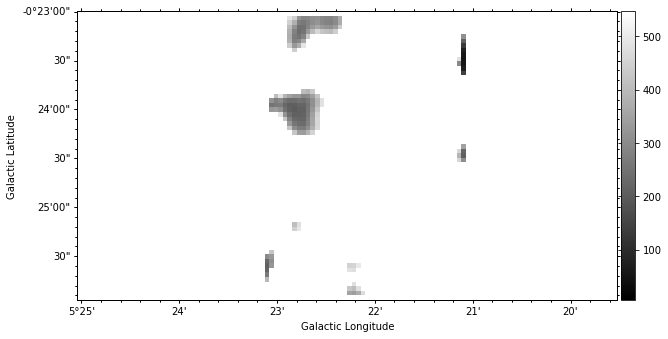

In [118]:
ratio_bridge_31 = sub_cube.with_mask(trap[:, None, :]).moment0(axis=0) / sub_cube_31.with_mask(trap[:, None, :]).moment0(axis=0)
ratio_bridge_31[ratio_bridge_31<0] = np.nan
ratio_bridge_31[ratio_bridge_31>500] = np.nan
ratio_bridge_31.quicklook()
#levs = ratio_bridge.FITSFigure.show_contour(ratio_bridge.hdu, returnlevels=True)


In [113]:
print(np.nanmin(ratio_bridge_31), np.nanmax(ratio_bridge_31), np.nanmean(ratio_bridge_31), np.nanmedian(ratio_bridge_31))

48.83717292842973 399.25668457126676 284.24189129589564 293.05943632866575


In [114]:
def F_1218(tau, R=200, A=250):
    return R - funct(tau, A)

In [115]:
taus_bridge_31 = np.ones(np.nan_to_num(ratio_bridge_31).shape)
rat_bridge_31 = np.nan_to_num(ratio_bridge_31)

for t in range(len(taus_bridge_31)):
    taus_bridge_31[t] = (fsolve(F_1218, taus_bridge_31[t], rat_bridge_31[t]))*(rat_bridge_31[t] != 0)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/scratch/local/55074977/ipykernel_31561/2822913080.py:3: RuntimeWarning: overflow encountered in power
  return (1-np.e**(-tau))/(1-np.e**(-tau/A))
/scratch/local/55074977/ipykernel_31561/2822913080.py:3: RuntimeWarning: invalid value encountered in divide
  return (1-np.e**(-tau))/(1-np.e**(-tau/A))


INFO: Auto-setting vmin to -6.962e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.675e+01 [aplpy.core]


array([-0.87009055, 14.36024513, 29.5905808 , 44.82091648, 60.05125215])

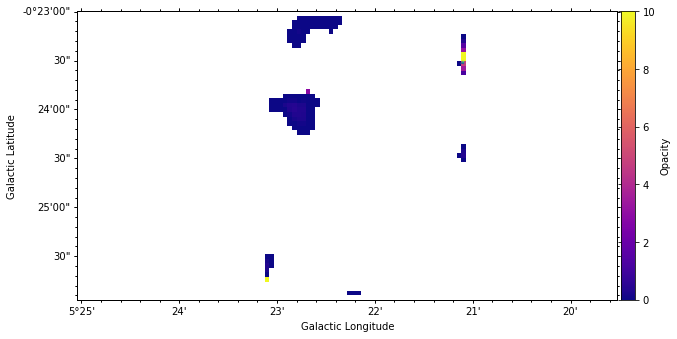

In [116]:
pro31_bridge = Projection(value=taus_bridge_31, wcs=ratio_bridge_31.wcs)
pro31_bridge[pro31_bridge==0] = np.nan
#pro31_bridge[pro31_bridge>10] = np.nan
pro31_bridge.quicklook()
pro31_bridge.FITSFigure.show_colorscale(cmap='plasma', vmin=0, vmax=10)
pro31_bridge.FITSFigure.colorbar.set_axis_label_text('Opacity')
pro31_bridge.FITSFigure.show_contour(pro31_bridge.hdu, returnlevels=True)

In [117]:
print(np.nanmin(pro31_bridge), np.nanmax(pro31_bridge), np.nanmean(pro31_bridge), np.nanmedian(pro31_bridge))

-0.8762177445552016 72.52740155509069 0.7200236418406744 -0.297148849844931
